# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
from scipy import stats
import math

from dtw import dtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

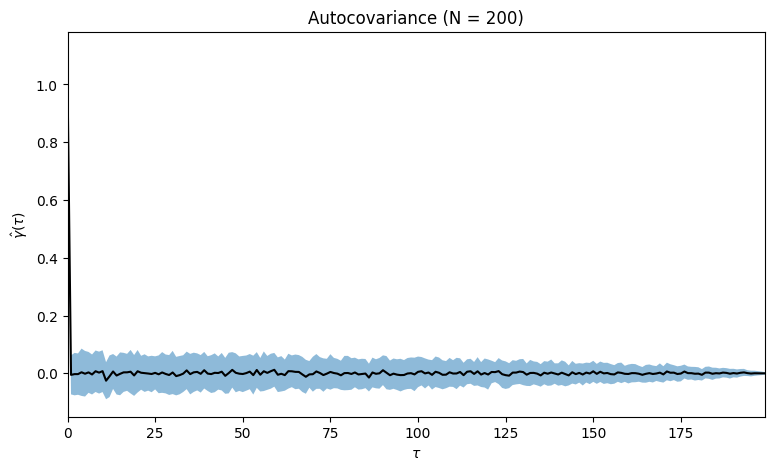

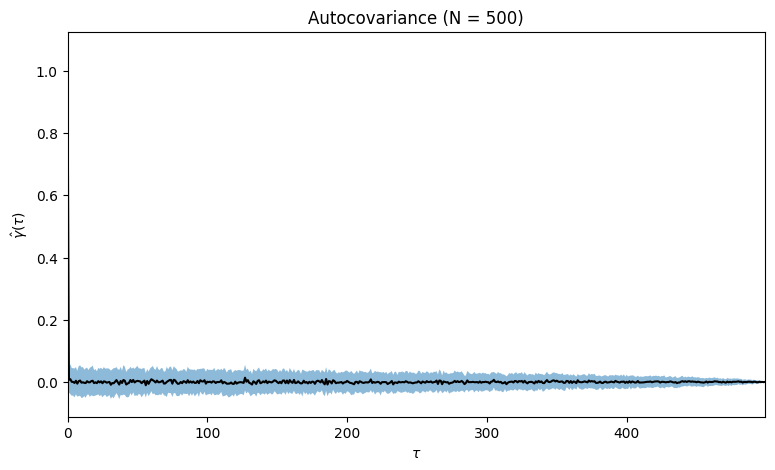

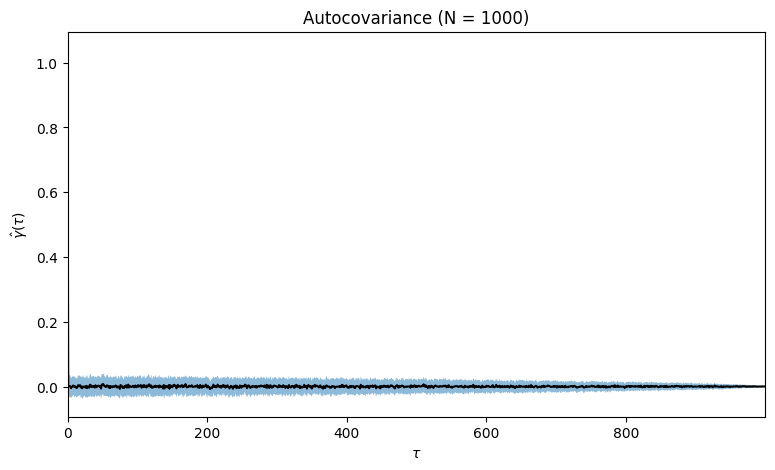

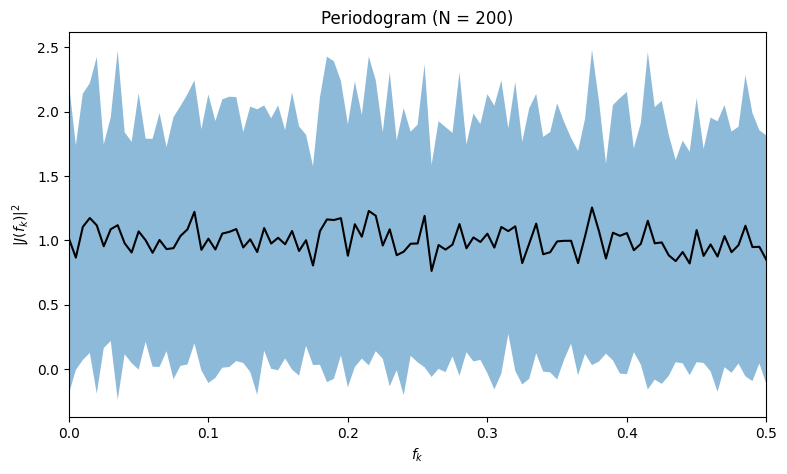

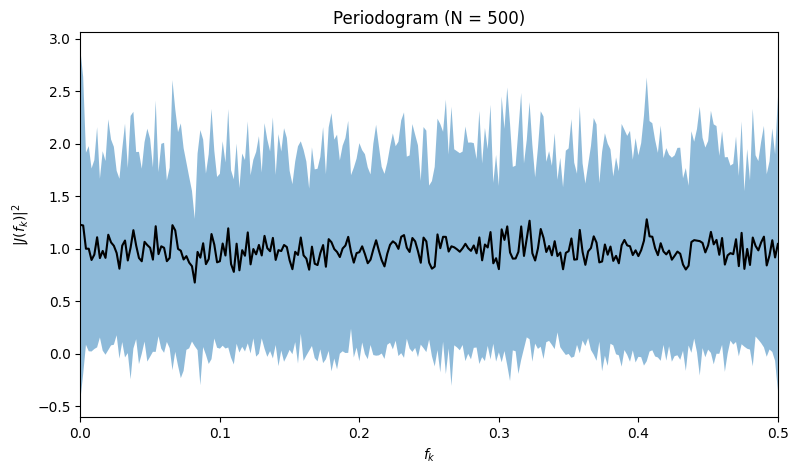

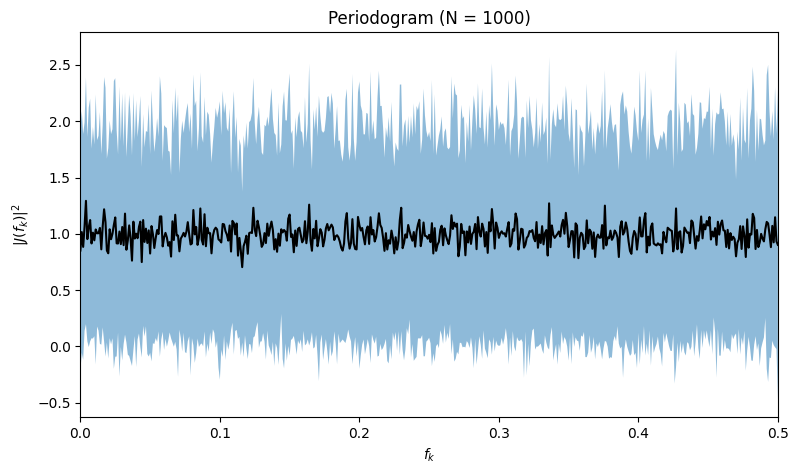

In [3]:
def sample_autocovariance(X, N):
    autocovariances = np.zeros(N)
    for tau in range(N):
        autocovariances[tau] = (1 / N) * np.sum(X[:N-tau] * X[tau:])
    return autocovariances


def compute_periodogram(autocovariances, N):
    periodogram = np.zeros(1 + (N//2))
    for k in range(1 + (N//2)):
        first_term = autocovariances[0]
        second_term = np.sum(2 * autocovariances[1:] * np.cos(2 * np.pi * k * np.arange(1, N) / N))
        periodogram[k] = first_term + second_term
    return periodogram


N_values = [200, 500, 1000]
n_simulations = 100
sigma2 = 1
f_s = 1

# Autocovariances

for N in N_values:
    autocovariances_simulations = np.zeros((n_simulations, N))
    
    for i in range(n_simulations):
        X = stats.norm.rvs(loc=0, scale=sigma2, size=N)
        autocovariances_simulations[i, :] = sample_autocovariance(X, N)
    
    avg_autocovariance = autocovariances_simulations.mean(axis=0)
    std_autocovariance = autocovariances_simulations.std(axis=0)
    
    taus = np.arange(N)

    fig, ax = fig_ax(figsize=(9, 5))
    ax.plot(taus, avg_autocovariance, 'k-')
    ax.fill_between(taus, avg_autocovariance - std_autocovariance, 
                    avg_autocovariance + std_autocovariance, alpha=0.5)
    ax.set_title(f"Autocovariance (N = {N})")
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel(r'$\hat{\gamma}(\tau)$')
    plt.show()

# Periodograms

for N in N_values:
    # (1 + (N//2)) because k = 0, 1, 2, ..., N/2 -> therefore math.floor(N/2) + 1 (the "+1" for k=0)
    periodograms_simulations = np.zeros((n_simulations, 1 + (N//2)))
    
    for i in range(n_simulations):
        X = stats.norm.rvs(loc=0, scale=sigma2, size=N)
        autocovariances = sample_autocovariance(X, N)
        periodograms_simulations[i, :] = compute_periodogram(autocovariances, N)
    
    avg_periodogram = np.mean(periodograms_simulations, axis=0)
    std_periodogram = np.std(periodograms_simulations, axis=0)
    
    f_k = np.arange(len(avg_periodogram)) * 1 / N

    fig, ax = fig_ax(figsize=(9, 5))
    ax.plot(f_k, avg_periodogram, 'k-')
    ax.fill_between(f_k, avg_periodogram - std_periodogram, 
                    avg_periodogram + std_periodogram, alpha=0.5)
    ax.set_title(f"Periodogram (N = {N})")
    ax.set_xlabel(r'$f_k$')
    ax.set_ylabel(r'$| J(f_k) |^2$')
    plt.show()


## Question 9

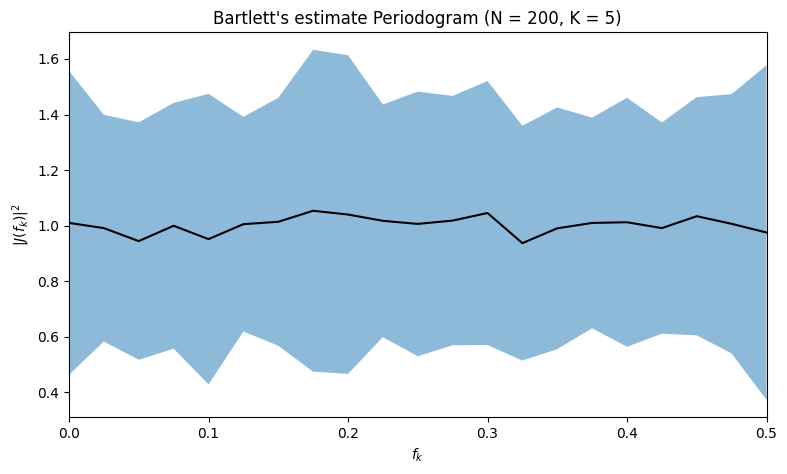

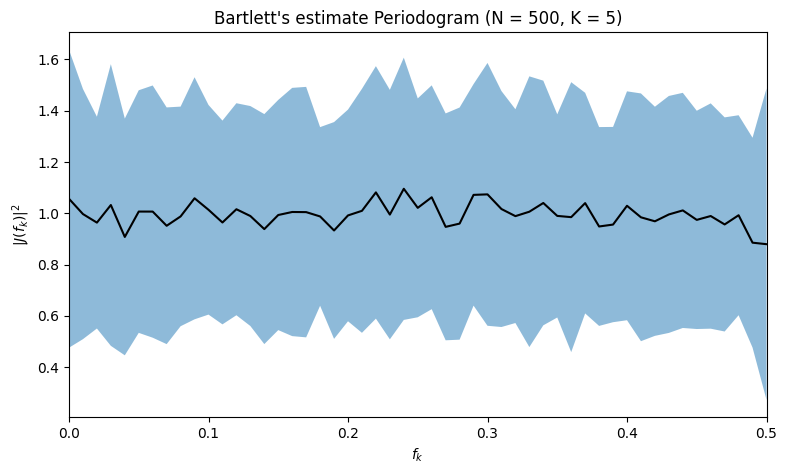

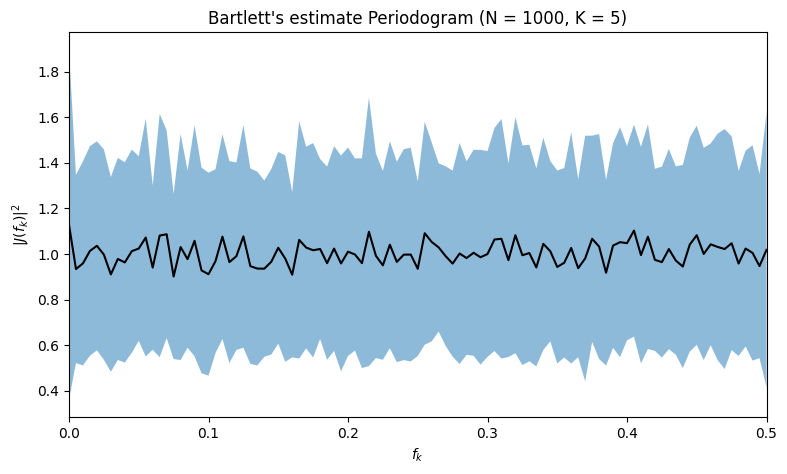

In [4]:
# Parameters
N_values = [200, 500, 1000]
n_simulations = 100
sigma2 = 1
f_s = 1
K = 5

for N in N_values:
    section_length = N // K
    periodograms_simulations = np.zeros((n_simulations, 1 + (section_length // 2)))
    
    for i in range(n_simulations):
        X = stats.norm.rvs(loc=0, scale=sigma2, size=N)
        segment_periodograms = np.zeros((K, 1 + (section_length // 2)))
        
        for j in range(K):
            X_segment = X[j*section_length:(j+1)*section_length]
            autocovariances = sample_autocovariance(X_segment, section_length)
            segment_periodograms[j, :] = compute_periodogram(autocovariances, section_length)
        
        periodograms_simulations[i, :] = np.mean(segment_periodograms, axis=0)
    
    avg_periodogram = np.mean(periodograms_simulations, axis=0)
    std_periodogram = np.std(periodograms_simulations, axis=0)
    
    f_k = np.arange(len(avg_periodogram)) * f_s / section_length

    fig, ax = fig_ax(figsize=(9, 5))
    ax.plot(f_k, avg_periodogram, 'k-')
    ax.fill_between(f_k, avg_periodogram - std_periodogram, 
                    avg_periodogram + std_periodogram, alpha=0.5)
    ax.set_title(f"Bartlett's estimate Periodogram (N = {N}, K = {K})")
    ax.set_xlabel(r'$f_k$')
    ax.set_ylabel(r'$| J(f_k) |^2$')
    plt.show()

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [5]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

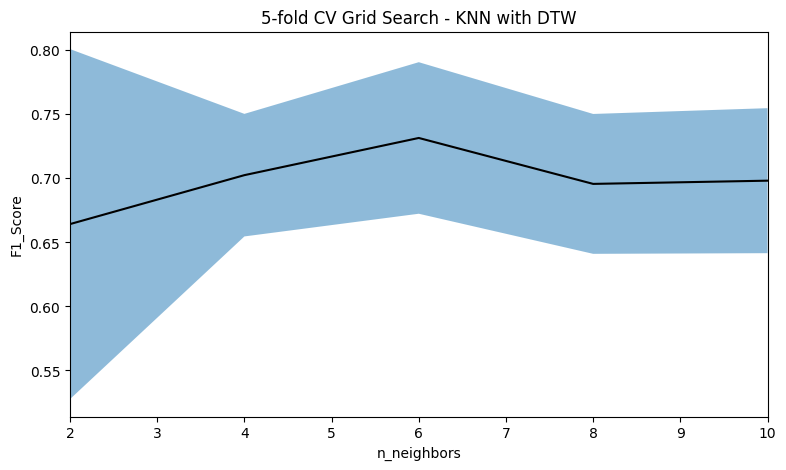

In [6]:
def compute_dtw_distance(X,Y):
    alignment = dtw(X,Y,keep_internals=False)
    return alignment.distance

# Make sure all instances have the same length
def pad_sequences(X, max_len):
    padded_X = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=1) for seq in X])
    return padded_X

max_len = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))

X_train_padded = pad_sequences(X_train, max_len)
X_test_padded = pad_sequences(X_test, max_len)

parameters = {'n_neighbors': [2, 4, 6, 8, 10], 'metric': [compute_dtw_distance]}
knn = KNeighborsClassifier()

clf = GridSearchCV(knn, parameters, scoring="f1")
clf.fit(X_train_padded, y_train)

mean_f1_scores = clf.cv_results_['mean_test_score']
std_f1_scores = clf.cv_results_['std_test_score']
n_neighbors_values = parameters['n_neighbors']



fig, ax = fig_ax(figsize=(9, 5))
ax.plot(n_neighbors_values, mean_f1_scores, 'k-')
ax.fill_between(n_neighbors_values, mean_f1_scores - std_f1_scores, 
                mean_f1_scores + std_f1_scores, alpha=0.5)
ax.set_title(f"5-fold CV Grid Search - KNN with DTW")
ax.set_xlabel(r'n_neighbors')
ax.set_ylabel(r'F1_Score')
plt.show()

## Question 11

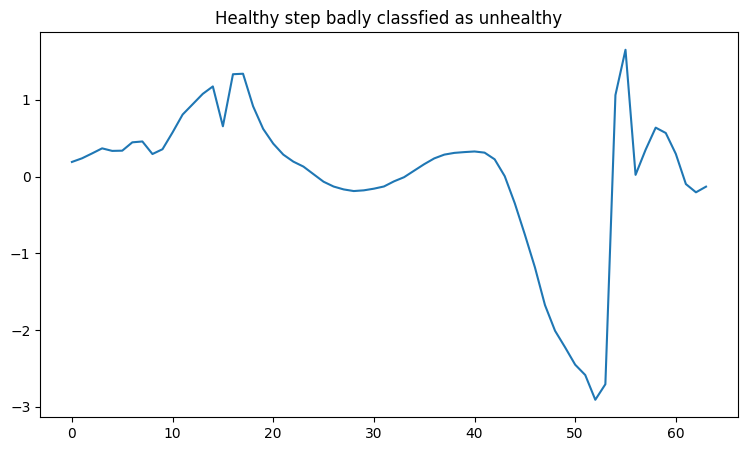

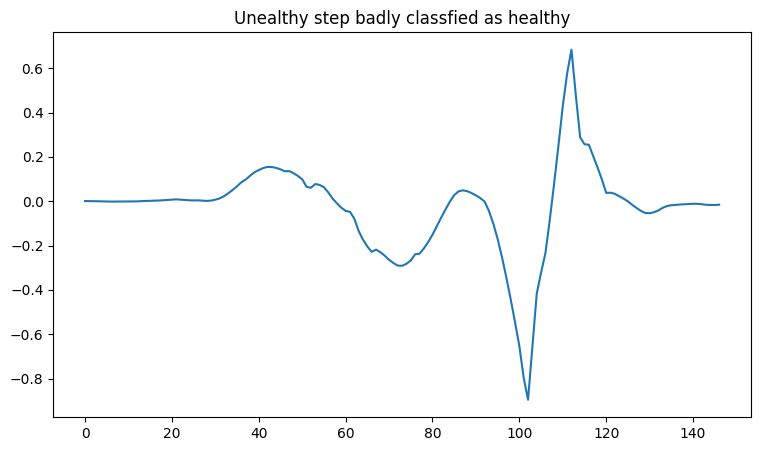

In [7]:
# We will use the optimal hyperparameters found in the last question
knn_opt = KNeighborsClassifier(**clf.best_params_)
knn_opt.fit(X_train_padded, y_train)
predictions = knn_opt.predict(X_test_padded)

for idx, prediction in enumerate(predictions):
  if prediction == 1 and y_test[idx] == 0:
    pred1_gold0 = idx
    break

for idx, prediction in enumerate(predictions):
  if prediction == 0 and y_test[idx] == 1:
    pred0_gold1 = idx
    break

plt.figure(figsize=(9, 5))
plt.plot(X_test[pred1_gold0])
plt.title("Healthy step badly classfied as unhealthy")
plt.show()

plt.figure(figsize=(9, 5))
plt.plot(X_test[pred0_gold1])
plt.title("Unealthy step badly classfied as healthy")
plt.show()